**Importing packages**

In [134]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
# changing current working directory

import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


In [136]:
# install torch

!pip install torch
import torch
import torch.nn as nn

In [137]:
# specify GPU

device = torch.device("cuda")

In [138]:
# defining SEED

import random
import numpy as np
import pandas as pd

SEED = 132
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True 

In [139]:
# installing transformers

!pip install transformers
from transformers import BertTokenizer

**Importing Dataset**

In [140]:
# Intializing the parameters for reading the dataset

columns = ['target','ids','date','flag','user','text']
encoding = "ISO-8859-1"

# Reading dataset

dataset_twitter = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv',
                              header = None, encoding = encoding, names = columns)

# Dropping the not required columns

dataset_twitter = dataset_twitter.drop(columns = ['ids', 'date', 'flag', 'user'])

# Replacing the target class '4' with '1'

dataset_twitter['target'].replace({4: 1}, inplace=True)

In [141]:
dataset_twitter

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [142]:
#Sample data

dataset_twitter.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [143]:
# counting number of target values

dataset_twitter['target'].value_counts()

1    800000
0    800000
Name: target, dtype: int64

In [144]:
# testing on stratifying code

df = pd.DataFrame(dict(
    A=[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
    B=range(13)
))

df.groupby('A', group_keys=False).apply(lambda x: x.sample(int(np.rint(8*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

,A,B
0,1,3
1,1,0
2,2,7
3,2,11
4,1,5
5,2,8
6,2,10
7,1,4


In [145]:
# stratifying and sampling dataset of 80,000 rows

dataset_stratify = dataset_twitter.groupby('target', group_keys=False).apply(lambda x: x.sample(int(np.rint(80000*len(x)/len(dataset_twitter))))).sample(frac=1).reset_index(drop=True)

In [146]:
dataset_stratify['target'].value_counts()

1    40000
0    40000
Name: target, dtype: int64

In [147]:
# Checking Null values

dataset_stratify.isnull().sum()

target    0
text      0
dtype: int64

**Preprocess the data**

In [148]:
# Preprocessing the data - claning the data of noise such as special characters, nametags

import re
def text_preprocessing(text):

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove '?'
    text = re.sub(r'\?', ' ', text).strip()

    # Remove ','
    text = re.sub(r'\,', '', text).strip()

    return text

In [149]:
# testing the preprocessing function

t = '@name, How you been?'
print('Original: ', t)
print('Processed: ', text_preprocessing(t))

Original:  @name, How you been?
Processed:  How you been


In [150]:
dataset_stratify['text']

0                        @ishinee WANNA SEE ? I GOT GMAIL 
1        thanks haha sana.XD pressurized ka... wag! eas...
2                                @underexpose  long GFJM09
3        my BPI card got captured....  have no money na...
4        Sitting here on the computer bored. Oh, and th...
                               ...                        
79995                                         on the road 
79996    @Mayerinated happy birthday! Hope you have a g...
79997    Why do you always think me in that way?! I hat...
79998    @simonmcconico well MGD, Lite or 64 all qualif...
79999    @Wendym00n yeah i don't watch a lot of new mov...
Name: text, Length: 80000, dtype: object

In [151]:
# preprocessing the dataset

dataset_stratify['text'] = dataset_stratify['text'].apply(lambda x: text_preprocessing(x))

In [152]:
dataset_stratify['text']

0                                  WANNA SEE   I GOT GMAIL
1        thanks haha sana.XD pressurized ka... wag! eas...
2                                              long GFJM09
3        my BPI card got captured.... have no money na ...
4        Sitting here on the computer bored. Oh and thi...
                               ...                        
79995                                          on the road
79996           happy birthday! Hope you have a great day!
79997    Why do you always think me in that way ! I hat...
79998    well MGD Lite or 64 all qualify.. you can lime...
79999    yeah i don't watch a lot of new movies. actual...
Name: text, Length: 80000, dtype: object

**Splitting Dataset**

In [153]:
# sampling the data of 80,000 rows

dataset_stratify = dataset_stratify.sample(n = 80000, random_state = SEED).reset_index(drop=True)

In [154]:
dataset_stratify.head()

,target,text
0,1,i've got a good feeling that YOU won
1,0,looking at pictures being mopey
2,1,about which part the disgusting fat lip or exc...
3,0,but i do still like her and want to see her in...
4,0,Looks like I'm gonna have to find Alvin a new ...


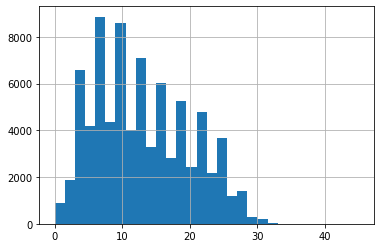

In [155]:
# get length of the words

word_len = [len(i.split()) for i in dataset_stratify['text']]

pd.Series(word_len).hist(bins = 30)

In [156]:
# finding maximum length of words to do padding

max_word_len = max(word_len)
max_word_len

45

In [157]:
# splitting the sampled dataset into stratified train, validation, and test sets

from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train, test = train_test_split(dataset_stratify, test_size=0.38, random_state=SEED, stratify = dataset_stratify.target)
train, val = train_test_split(train, test_size=0.3,random_state=SEED, stratify = train.target)

In [158]:
train.value_counts('target')

target
1    17360
0    17360
dtype: int64

In [159]:
val.value_counts('target')

target
1    7440
0    7440
dtype: int64

In [160]:
test.value_counts('target')

target
1    15200
0    15200
dtype: int64

In [161]:
train.head()

,target,text
20683,1,the mary jane kind - they have mickey heads in...
57014,1,waking up to birds singing and raindrops' rhyt...
70935,1,idk!
37427,0,aww I'm sorry! That sucks.
29909,0,GRR!!! Looked at Cannon Cameras online for HOU...


**BERT Tokenization**

In [162]:
# importing packages for tokenization

!pip install transformers
import transformers
from transformers import AutoModel, BertTokenizerFast

In [163]:
# splitting train, validation and test sets into respective text and target sets

temp_text, test_text, temp_targets, test_targets = train_test_split(dataset_stratify['text'], dataset_stratify['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.36, 
                                                                    stratify=dataset_stratify['target'])

# we will use temp_text and temp_targets to create train and validation set
train_text, val_text, train_targets, val_targets = train_test_split(temp_text, temp_targets, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_targets)

In [164]:
val_targets.value_counts('target')

1    0.5
0    0.5
Name: target, dtype: float64

In [165]:
# import BERT-base pretrained model

bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [166]:
# testing tokenizer with sample data

text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

sent_id_ex = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
sent_id_ex

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [167]:
train_text

6547             Thanks for the feedback Much appreciated.
25253    Sad times at the minute! my grandad is terminl...
64096    i can't wait! &quot;Look At My Twitter&quot; w...
35072    lilivonshtupp Nachos are not in my diet might ...
73739    Ha! Ok you can only come up with one because I...
                               ...                        
44689     Just never be sad  becuse no bady cry for you ..
72414         Drinking Orange juice which tastes like shit
32995    and so another week begins. this one has got t...
78532    Get 100 followers a day using www.tweeterfollo...
10046    wow that must hurt a lot! Your whole back is b...
Name: text, Length: 25600, dtype: object

In [168]:
# tokenize and encode sequences in the training set

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_word_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_word_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_word_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Convert Integer Sequences to Tensors**

In [169]:
# inputs and attention masks for train set

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_targets.tolist())

# inputs and attention masks for validation set

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_targets.tolist())

# inputs and attention masks for test set

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_targets.tolist())

**Create DataLoaders**

In [170]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size

batch_size = 32

# tensor for train set

train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training

train_sampler = RandomSampler(train_data)

# dataLoader for train set

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# tensor for validation set

val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training

val_sampler = SequentialSampler(val_data)

# dataLoader for validation set

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

**Freeze BERT Parameters**

In [171]:
# freeze all the BERT parameters

for param in bert.parameters():
    param.requires_grad = False


**Define Model Architecture**

In [206]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      D_in, H, O, D_out = 768, 512, 128, 2

      self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, O),
            nn.Sigmoid(),
            nn.Linear(O, D_out),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, sent_id, mask):

      cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.classifier(cls_hs[0][:,0,:])

      return x

In [207]:
# passing the pre-trained BERT to define architecture

model = BERT_Arch(bert)

model = model.to(device)

In [208]:
# optimizer

from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 3e-4)

**Find Class Weights**

In [209]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight('balanced', np.unique(train_targets), train_targets)
print(class_wts)

[1. 1.]


In [210]:
# converting class weights to tensor

weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function

cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs

epochs = 5

**Fine-Tune BERT**

In [211]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  total_preds=[]
  train_accuracy = []

  for step,batch in enumerate(train_dataloader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    sent_id, mask, targets = tuple(r.to(device) for r in batch)
    model.zero_grad()        
    preds = model(sent_id, mask)
    logits = torch.argmax(preds, dim=1).flatten()
    accuracy = (logits == targets).cpu().numpy().mean() * 100
    train_accuracy.append(accuracy)
    loss = cross_entropy(preds, targets)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)
  train_accuracy = np.mean(train_accuracy)

  return avg_loss, total_preds, train_accuracy

In [212]:
import random
import time

# function for evaluating the model

def evaluate():
  
  print("\nEvaluating...")
  
  model.eval()

  total_loss, total_accuracy= 0, 0
  total_preds = []
  val_accuracy = []

  for step,batch in enumerate(val_dataloader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    sent_id, mask, targets = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      preds = model(sent_id, mask)
      logits = torch.argmax(preds, dim=1).flatten()
      accuracy = (logits == targets).cpu().numpy().mean() * 100
      val_accuracy.append(accuracy)
      loss = cross_entropy(preds,targets)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)
  val_accuracy = np.mean(val_accuracy)

  return avg_loss, total_preds, val_accuracy

**Start Model Training**

In [213]:
best_valid_loss = float('inf')

train_losses=[]
val_losses=[]

for epoch in range(epochs):
     
    train_accuracy = []
    val_accuracy = []
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, preds, train_acc = train()
    val_loss, preds, val_acc = evaluate()
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    train_accuracy = np.mean(train_accuracy)
    val_accuracy = np.mean(val_accuracy)

    print(f'\n Epoch: {epoch: 1f}')
    print(f'\nTraining Loss: {train_loss:.3f}', "   ||    ", f'Training Accuracy: {train_accuracy:.3f}')
    print(f'\nValidation Loss: {val_loss:.3f}', "   ||    ", f'Validation Accuracy: {val_accuracy:.3f}')


 Epoch 1 / 5
  Batch    50  of    800.
  Batch   100  of    800.
  Batch   150  of    800.
  Batch   200  of    800.
  Batch   250  of    800.
  Batch   300  of    800.
  Batch   350  of    800.
  Batch   400  of    800.
  Batch   450  of    800.
  Batch   500  of    800.
  Batch   550  of    800.
  Batch   600  of    800.
  Batch   650  of    800.
  Batch   700  of    800.
  Batch   750  of    800.

Evaluating...
  Batch    50  of    800.
  Batch   100  of    800.
  Batch   150  of    800.
  Batch   200  of    800.
  Batch   250  of    800.
  Batch   300  of    800.
  Batch   350  of    800.
  Batch   400  of    800.
  Batch   450  of    800.
  Batch   500  of    800.
  Batch   550  of    800.
  Batch   600  of    800.
  Batch   650  of    800.
  Batch   700  of    800.
  Batch   750  of    800.

 Epoch:  0.000000

Training Loss: 0.525    ||     Training Accuracy: 73.828

Validation Loss: 0.496    ||     Validation Accuracy: 75.957

 Epoch 2 / 5
  Batch    50  of    800.
  Batch   10

**Load Saved Model**

In [214]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Get Predictions for Test Data**

In [215]:
test_text.sample(5)

26273    I can't wait to welcome Mana to our ohana! OOO...
54037    dang it...looks like I have to work this weeke...
63912    I love you wifey Kimmie & Nye for tonight's ad...
9772                              very sorry to hear that.
38596    its GROSS we had two frogs in there the other ...
Name: text, dtype: object

In [216]:
test_targets.sample(5)

77838    1
40233    0
17098    1
63704    0
55638    1
Name: target, dtype: int64

In [217]:
# Create the DataLoader for test set

test_dataset = TensorDataset(test_seq, test_mask)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

**Prediction on Test Set**

In [218]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):

    model.eval()

    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


AUC: 0.8659
Accuracy: 78.28%


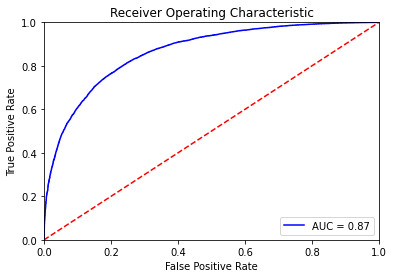

In [220]:
# Compute predicted probabilities on the test set

probs = bert_predict(model, test_dataloader)

# Evaluate the Bert classifier

evaluate_roc(probs, test_targets)